# TP : Sentiment analysis on IMDB movie reviews

## Objectives

1. Implement a simple way to represent text data - Bag of words
2. Implement a basic statistical learning model - Bayesian Naive
3. Use these representations and this model for a sentiment analysis task.
4. Experiment with various way to reduce the vocabulary size and look at the distribution obtained.

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt


## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [2]:
from glob import glob
# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb','train','neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.','aclImdb','train', 'pos', '*.txt')))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

print(len(train_texts))

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[:len(train_texts_neg)] = 0.


25000


In [3]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**In this lab, the impact of our choice of representations upon our results will also depend on the quantity of data we use:** try to see how changing the parameter ```k``` affects our results !

In [4]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Number of documents:', len(train_texts_reduced))

Number of documents: 2500


We can use a function from sklearn, ```train_test_split```, to separate data into training and validation sets:

In [5]:
from sklearn.model_selection import train_test_split

c:\Users\pcd\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
#By default it splits the data into two sets the training and the test 75% for the train and 25% for the test

train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

## I - Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [8]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())
Bow.toarray();
print(Bow.toarray())

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']
[[0 1 0 2 0 1 0 1]
 [1 0 0 1 0 1 0 1]
 [0 1 0 1 1 1 0 0]
 [0 0 1 1 0 1 1 0]
 [1 0 0 1 0 2 1 0]]


c:\Users\pcd\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

### Preprocessing the text: get the BoW representations ##

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words). 
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations. 
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains many different *tokenizers*.

In [9]:
# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(clean_and_tokenize(corpus_raw))
# so here using the word_tokenize does not allows us to remove the words that are constructed by one or 2 characters. 
print(word_tokenize(corpus_raw))


['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    #
    # To complete
    # first let us get all the unique words from the data
    all_features = [] 
    for element in texts:
        aux = clean_and_tokenize(element)
        for word in aux:
            if word not in all_features:
                all_features.append(word)
    # now convert it to dictionary
    vocabulary = {word: index for index, word in enumerate(all_features)}

    #create the matrix
    counts = np.zeros((len(texts),len(all_features)))
    
    for i in range(len(texts)):
        for feature,j in vocabulary.items():
            if feature in texts[i].split():
                counts[i,j] = (texts[i].split()).count(feature)   


    return vocabulary, counts

In [11]:
Voc, X = count_words(corpus)
print(corpus)
print(Voc)
print(X)

['I walked down down the boulevard', 'I walked down the avenue', 'I ran down the boulevard', 'I walk down the city', 'I walk down the the avenue']
{'walked': 0, 'down': 1, 'the': 2, 'boulevard': 3, 'avenue': 4, 'ran': 5, 'walk': 6, 'city': 7}
[[1. 2. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 1.]
 [0. 1. 2. 0. 1. 0. 1. 0.]]


Now, if we want to represent text that was not available when building the vocabulary, we will not be able to represent **new words** ! Let's take a look at how CountVectorizer does it:

In [12]:
val_corpus = ['I walked up the street']
Bow = vectorizer.transform(val_corpus)
Bow.toarray();
print(Bow.toarray())
print("Here it's clear that the new words are well-ignored")



[[0 0 0 0 0 1 0 1]]
Here it's clear that the new words are well-ignored


Modify the ```count_words``` function to be able to deal with new documents when given a previously obtained vocabulary ! 

<div class='alert alert-block alert-info'>
            Code:</div>

In [13]:
def count_words(texts, voc = None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    voc : dict
        A dictionary that points to an index in counts for each word - output by a previous use of the function
        If not None, use this one
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    if voc == None:
    #
    # To complete
        all_features = [] 
        for element in texts:
            aux = clean_and_tokenize(element)
            for word in aux:
                if word not in all_features:
                    all_features.append(word)
        # now convert it to dictionary
        vocabulary = {word: index for index, word in enumerate(all_features)}

        #create the matrix
        counts = np.zeros((len(texts),len(all_features)))
        
        for i in range(len(texts)):
            for feature,j in vocabulary.items():
                if feature in texts[i].split():
                    counts[i,j] = (texts[i].split()).count(feature) 
        
    #
    else:
    # 
    # To complete
        vocabulary = voc
        counts = np.zeros((len(texts), len(voc)))

        for i in range(len(texts)):
            for feature,j in vocabulary.items():
                if feature in texts[i].split():
                    counts[i,j] = (texts[i].split()).count(feature) 
        
    #
    return vocabulary, counts

<div class='alert alert-block alert-warning'>
            Questions:</div>                       

Careful: check the size that the representations are going to have (given the way they are build). What does this imply for the memory use ? What ```CountVectorizer``` argument allows to avoid the issue ?

<div class='alert alert-block alert-info'>
            Code:</div>

Answer: 

the problem is that we create a full matrix where its size is very huge, that allows the matrix to be very sparse, that means most of its elements could be zeros, because any document is likely to contain only small subset if the entire vocabulary,leaving most of the matix's element szero,especailly when our vocabulary is large.So this increases the memory usage.

For countvectorizer stores the representations in sparse format instead of dense format, where the non-zero only is stored, reducing the memory usage when dealing with large or sparse data.

In [15]:
voc, train_bow = count_words(train_texts_splt)
print(voc)
print(len(train_bow))

{'this': 0, 'movie': 1, 'was': 2, 'pretty': 3, 'absurd': 4, 'there': 5, 'few': 6, 'funny': 7, 'parts': 8, 'its': 9, 'goes': 10, 'right': 11, 'the': 12, 'bin': 13, 'movies': 14, 'memory': 15, 'where': 16, 'think': 17, 'hmmthat': 18, 'had': 19, 'but': 20, 'overall': 21, 'ridiculous': 22, 'plot': 23, 'lack': 24, '<': 25, '><': 26, '>': 27, 'thought': 28, 'seemed': 29, 'like': 30, 'ben': 31, 'trying': 32, 'little': 33, 'too': 34, 'hard': 35, 'cooky': 36, 'guy': 37, 'and': 38, 'didnt': 39, 'understand': 40, 'how': 41, 'self': 42, 'made': 43, 'multi': 44, 'millionaire': 45, 'still': 46, 'such': 47, 'idiot': 48, 'anyways': 49, 'affleck': 50, 'makes': 51, 'some': 52, 'crap': 53, 'hey': 54, 'can': 55, 'forgive': 56, 'him': 57, 'mean': 58, 'liked': 59, 'jersey': 60, 'girl': 61, 'gigli': 62, 'all': 63, 'his': 64, 'fault': 65, 'guess': 66, 'hes': 67, 'kinda': 68, 'kid': 69, 'you': 70, 'feel': 71, 'sorry': 72, 'for': 73, 'cuz': 74, 'just': 75, 'cant': 76, 'seem': 77, 'get': 78, 'right<': 79, 'advic

In [16]:
_, val_bow = count_words(val_texts, voc= voc)
print(val_bow.shape)
print(np.max(val_bow))

(500, 29832)
80.0


In [17]:
# Do the same with a CountVectorizer: create and fit the vectorizer to the training data

vector_document = CountVectorizer()

matrix_occurency = vector_document.fit_transform(train_texts_splt)

print(vector_document.get_feature_names())

print(matrix_occurency.toarray())



['00', '000', '007', '02', '05', '07', '08', '09', '10', '100', '1000', '1000000', '100m', '101', '102', '103', '105', '10mil', '10th', '10yr', '11', '110', '11001001', '112', '12', '120', '1200f', '123', '125', '12s', '13', '134', '13th', '14', '145', '147', '14ieme', '15', '150', '16', '161', '1692', '16th', '17', '1798', '18', '180', '1800', '1824', '1840', '1850', '1864', '1889', '1892', '1895', '1897', '18th', '19', '1902', '1910', '1911', '1912', '1914', '1916', '1918', '1919', '1920', '1920s', '1921', '1922', '1924', '1925', '1927', '1928', '1929', '1930', '1930s', '1931', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1940s', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1950s', '1951', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1960s', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1970s', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1980ies'

In [18]:
# Transform the validation data

test_counts = vector_document.transform(val_texts)

test_counts = test_counts.toarray()

print(test_counts.shape)
print(test_counts[0:20,0:20])

print(np.max(test_counts))

(500, 25737)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
90


## II- Naive Bayesian 

### Main idea

A movie review is in fact a list of words $s = (w_1, ..., w_N)$, and we try to find the associated class $c$ - which in our case may be $c = 0$ or $c = 1$. The objective is thus to find for each review $s$ the class $\hat{c}$ maximizing the conditional probability **$P(c|s)$** : 

$$\hat{c} = \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)}$$

**Hypothesis : P(s) is constant for each class** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)} = \underset{c}{\mathrm{argmax}}\,P(s|c)P(c)$$

**Naive hypothesis : the variables (words) of a review are independant between themselves** : 

$$P(s|c) = P(w_1, ..., w_N|c)=\Pi_{i=1..N}P(w_i|c)$$

### General view

#### Training: Estimating the probabilities

For each word $w$ in the vocabulary $V$, $P(w|c)$ is the number of occurrences of $w$ in all reviews of class $c$, divided by the total number of occurrences in $c$. If we note $T(w,c)$ this number of occurrences, we get:

$$P(w|c) = \text{Frequency of }w\text{ in }c = \frac{T(w,c)}{\sum_{w' \in V} T(w',c)}$$

#### Test: Calculating scores

To facilitate the calculations and to avoid *underflow* and approximation errors, we use the log-sum trick, and we pass the equation into log-probabilities : 

$$ \hat{c} = \underset{c}{\mathrm{argmax}} P(c|s) = \underset{c}{\mathrm{argmax}} \left[ \mathrm{log}(P(c)) + \sum_{i=1..N}log(P(w_i|c)) \right] $$

#### Laplace smoothing

A word that does not appear in a document has a probability of zero: this will cause issues with the logarithm. So we keep a very small part of the probability mass that we redistribute with the *Laplace smoothing*: 

$$P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} (T(w',c) + 1)}$$

There are other smoothing methods, generally suitable for other, more complex applications. 

### Detail: training

The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\pmb{P}$ such that: $$\pmb{P}_{w,c} = P(w|c)$$

Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !

#### Procedure:

- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.
- Calculate the a priori probabilities of the classes $P(c) = \frac{|\text{documents in class }c|}{|\text{all documents}|}$
- Calculate the conditional **smoothed** probabilities $P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} T(w',c) + 1}$.

### Detail: test

We now know the conditional probabilities given by the $\pmb{P}$ matrix. 
Now we must obtain $P(s|c)$ for the current document. This quantity is obtained using a simple calculation involving the BoW representation of the document and $\pmb{P}$.

#### Procedure:

- For each of the classes $c$,
    - $Score(c) = \log P(c)$
    - For each word $w$ in the document to be tested:
        - $Score(c) += \log P(w|c)$
- Return $argmax_{c \in C} Score(c)$ 

We will therefore be able to use the reviews at our disposal to **estimate the probabilities $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how to evaluate the "compatibility" between words and classes.
```python
def fit(self, X, y)
``` 
**Training**: will learn a statistical model based on the representations $X$ corresponding to the labels $y$.
Here, $X$ contains representations obtained as the output of ```count_words```. You can complete the function using the procedure detailed above. 

Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\alpha$, which we can implement as an argument of the class "NB".

```python
def predict(self, X)
```
**Testing**: will return the labels predicted by the model for other representations $X$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [19]:
class NB(BaseEstimator, ClassifierMixin):
    # Les arguments de classe permettent l'héritage de classes de sklearn
    def __init__(self, alpha=1.0):
        # alpha is the smoothing parameter: it corresponds to line 10 of the training algorithm
        # By default, we use alpha = 1
        self.alpha = alpha
        
    def fit(self,X,y):
        self.class_ , count_class = np.unique(y,return_counts=True)
        self.class_probability = count_class/len(y)
        vocabulary_array = np.zeros((len(self.class_),X.shape[1]))
        for ind,class_value in enumerate(self.class_):
            # create mask
            mask = (y==class_value)
            data_class =  X[mask]
            k= np.sum(data_class,axis=0)
            #print(k)
            vocabulary_array[ind]= (k+self.alpha)/(np.sum(k)+self.alpha)
        self.vocabulary_prob = vocabulary_array

        return self
    def predict(self, X):
        log_prob = np.log(self.vocabulary_prob)
        log_prior = np.log(self.class_probability)
        scores = np.dot(X,log_prob.T) + log_prior
        predictions = np.argmax(scores, axis=1)
        result = self.class_[predictions]

        return result

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## III - Experimentation

Experiment on this model with your own representations. **Visualize** the results with the following tools, and **compare with the representations of ```CountVectorizer```/ naïve Bayes model of scikit-learn ```MultinomialNB```:**

<div class='alert alert-block alert-info'>
            Code:</div>

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB


the accuracy of the training set :  0.9545
the accuracy of the test set :  0.78


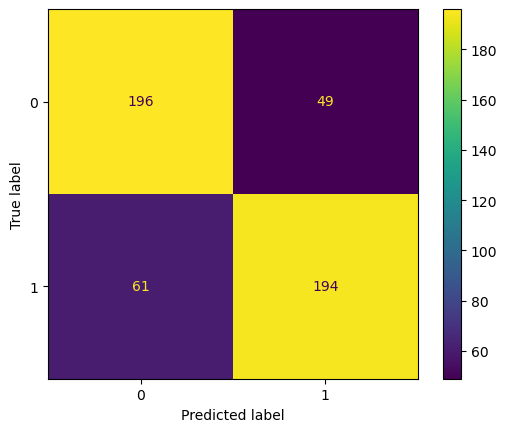

In [23]:
modelNB = NB()
# fit the model on the trained data obtained above 

modelNB.alpha = 1
modelNB.fit(train_bow,train_labels_splt)
train_accuracy = modelNB.score(train_bow,train_labels_splt)
test_accuracy = modelNB.score(val_bow,val_labels)
print("the accuracy of the training set : ",train_accuracy)
print("the accuracy of the test set : ",test_accuracy)


cm = confusion_matrix(val_labels, modelNB.predict(val_bow), labels=modelNB.class_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=modelNB.class_)
disp.plot()
plt.show()

the accuracy of the training set :  0.9535
the accuracy of the test set :  0.778


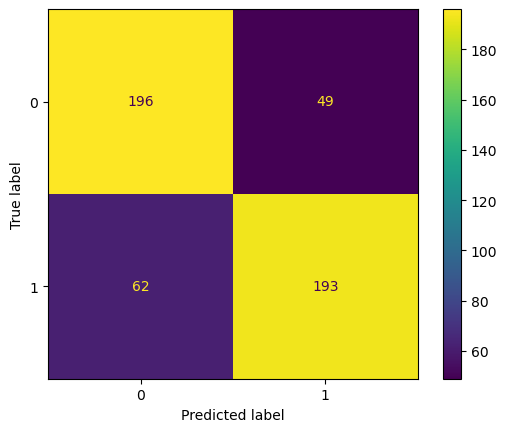

In [25]:
#  now let us use the naive bayes model using the sklearn
skl_model = MultinomialNB()

skl_model.fit(train_bow,train_labels_splt)

skl_train_accuracy = skl_model.score(train_bow,train_labels_splt)
skl_test_accuracy = skl_model.score(val_bow,val_labels)
print("the accuracy of the training set : ",skl_train_accuracy)
print("the accuracy of the test set : ",skl_test_accuracy)

cm = confusion_matrix(val_labels, skl_model.predict(val_bow), labels=skl_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=skl_model.classes_)
disp.plot()
plt.show()



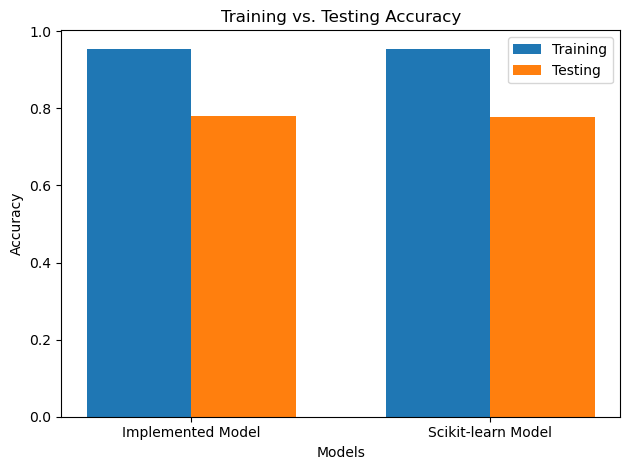

In [26]:
# display the result as bar chart to see the performance of each one 

# Model names
models = ['Implemented Model', 'Scikit-learn Model']

# Accuracy data
train_accuracies = [train_accuracy, skl_train_accuracy]
test_accuracies = [test_accuracy, skl_test_accuracy]

# Plotting
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(models))

bars1 = plt.bar(index, train_accuracies, bar_width, label='Training')
bars2 = plt.bar([p + bar_width for p in index], test_accuracies, bar_width, label='Testing')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training vs. Testing Accuracy')
plt.xticks([p + bar_width / 2 for p in index], models)
plt.legend()

plt.tight_layout()
plt.show()


Based on the bar chart above we can deduce that the naive bais model implemented using the sklearn and my own model are approximately at the same accuracy and efficient however we can say that our model is good as the accuracy exceeds 0.77. 

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
Let us look at the *features* built by the ```vectorizer```. What seems to be the issue ? 

In [27]:
print(vector_document.get_feature_names()[:100])

['00', '000', '007', '02', '05', '07', '08', '09', '10', '100', '1000', '1000000', '100m', '101', '102', '103', '105', '10mil', '10th', '10yr', '11', '110', '11001001', '112', '12', '120', '1200f', '123', '125', '12s', '13', '134', '13th', '14', '145', '147', '14ieme', '15', '150', '16', '161', '1692', '16th', '17', '1798', '18', '180', '1800', '1824', '1840', '1850', '1864', '1889', '1892', '1895', '1897', '18th', '19', '1902', '1910', '1911', '1912', '1914', '1916', '1918', '1919', '1920', '1920s', '1921', '1922', '1924', '1925', '1927', '1928', '1929', '1930', '1930s', '1931', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1940s', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1950s', '1951', '1953']


c:\Users\pcd\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Answer : 

As seen in the output the first 100 extracted features is numerical data (e.g. 1,2,3,4,77,..) these kind of data introduce somehow a noise rather that valuable information,that leads us to some problem such as increasing the dimentionality and reduce the performacnce. the only way to mitigate or get rid of these noisy data is to perform what we they called the preprocessing where we remove the less informative information keeping the significant features that are useful for our model.


### Improving representations

Mainly, the arguments of the class ```vectorizer``` will allow us to easily change the way our textual data is represented. Let us try to work on our *Bag-of-words* representations:
   
#### Do not take into account words that are too frequent:

You can use the argument ```max_df=1.0``` to change the amount of words taken into account. 

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course. 
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options ```analyze='word'``` and ```ngram_range=(1, 2)``` which we'll change to alter the granularity: **obtain classification results with them**.

Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with ! To accelerate experiments, use the ```Pipeline``` tool from scikit-learn. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [28]:
from sklearn.pipeline import Pipeline

In [29]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       245
           1       0.84      0.76      0.80       255

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



In [30]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_df=0.4,ngram_range=(1,2),max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       245
           1       0.85      0.79      0.82       255

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



It is clear that if we use the trick of max_df where we do not select the words that exist in almost 97% of the documents a quick example is "the" which exists in all the documents, then if we use the 2 gram or 3 gram we can see an increasing regarding the presicion and the recall as well as the f1-score especially in the testing evaluation.

In addition, if we set the value of the max_df to 0.4 we got a very good precision and a high f1-score.

#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 

Experiment with this new representations using the ```TfidfTransformer``` applied on top of ```CountVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

Test the model from sklearn.naive_bais where we use the 3gram

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer

# create the pipline

pipeline_TF_IDF = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3),max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       245
           1       0.85      0.79      0.82       255

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



Now we will design a pipline using the TfidfTransformer instead of CountVectorizer

In [32]:
pipeline_TF_IDF = Pipeline([
    ('vect', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt, train_labels_splt)
val_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels, val_pred))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       245
           1       0.85      0.79      0.82       255

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500



General model without using a pipline process

In [33]:
# define the vectorization 

vector_for_extraction = CountVectorizer()

# prepare the training and the test data as TF 

xtrain_using_vect = vector_for_extraction.fit_transform(train_texts_splt)

xtest_using_vect = vector_for_extraction.transform(val_texts)

# transform the TF into TF-IDF 

TF_TRANSFORMER = TfidfTransformer()

xtrain_using_TF_IDF = TF_TRANSFORMER.fit_transform(xtrain_using_vect)

xtest_using_TF_IDF = TF_TRANSFORMER.transform(xtest_using_vect)

# now define our model with its parameters 

model_TF_IDF = MultinomialNB()

model_TF_IDF.fit(xtrain_using_TF_IDF,train_labels_splt)

predicted_values = model_TF_IDF.predict(xtest_using_TF_IDF)

print(classification_report(val_labels,predicted_values))

              precision    recall  f1-score   support

           0       0.74      0.91      0.81       245
           1       0.89      0.69      0.77       255

    accuracy                           0.80       500
   macro avg       0.81      0.80      0.79       500
weighted avg       0.81      0.80      0.79       500



we can deduce that using TF-IDF is much better that using the basic one using the TF because in TF-IDF it focuses on each words and takes into account the importance of each word in all documents and when a word exists in one or two documents we gave it more wheight and more inportance 

moreever in most application when a word is very frequent that means this word exists in all the class and we can get rid of it and rather we focus on the words that has more significance importance.

see below the plot of the metrics that ensure and insists on what i have mentioned.

## IV - More pre-processing: getting vocabularies

For more flexibility, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, either by indicating a **maximum number of words**, or a **minimum number of occurrences** to take the words into account. **We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary**.
<div class='alert alert-block alert-info'>
            Code:</div>

In [34]:
def vocabulary(corpus, count_threshold=0, voc_threshold=10000):

    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary. Use "0" to indicate no limit 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency   
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts = {}
    for sent in corpus:
        tokens = sent.lower().split()
        for word in tokens:
            word_counts[word] = word_counts.get(word, 0) + 1
    filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}
    sorted_words = sorted(filtered_word_counts, key=filtered_word_counts.get, reverse=True)
    if voc_threshold and voc_threshold > 0:
        sorted_words = sorted_words[:voc_threshold]
    vocabulary = {word: idx for idx, word in enumerate(sorted_words)}
    vocabulary['unknown'] = len(vocabulary)
    counts = {word: filtered_word_counts.get(word, 0) for word in sorted_words}
    counts['unknown'] = 0



    return vocabulary, counts

In [35]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
# (In this example, we don't count 'UNK' unknown words, but you can if you want to. 
# How useful it may be depends on the data -> we will use the counts later with word2vec, keep that in mind) 
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus,count_threshold=0)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'i': 2, 'unknown': 3}
{'down': 6, 'the': 6, 'i': 5, 'unknown': 0}
{'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'unknown': 9}
{'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'unknown': 0}


### Quick study of the data

We would like to get an idea of what's in these film reviews. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

<div class='alert alert-block alert-info'>
            Code:</div>

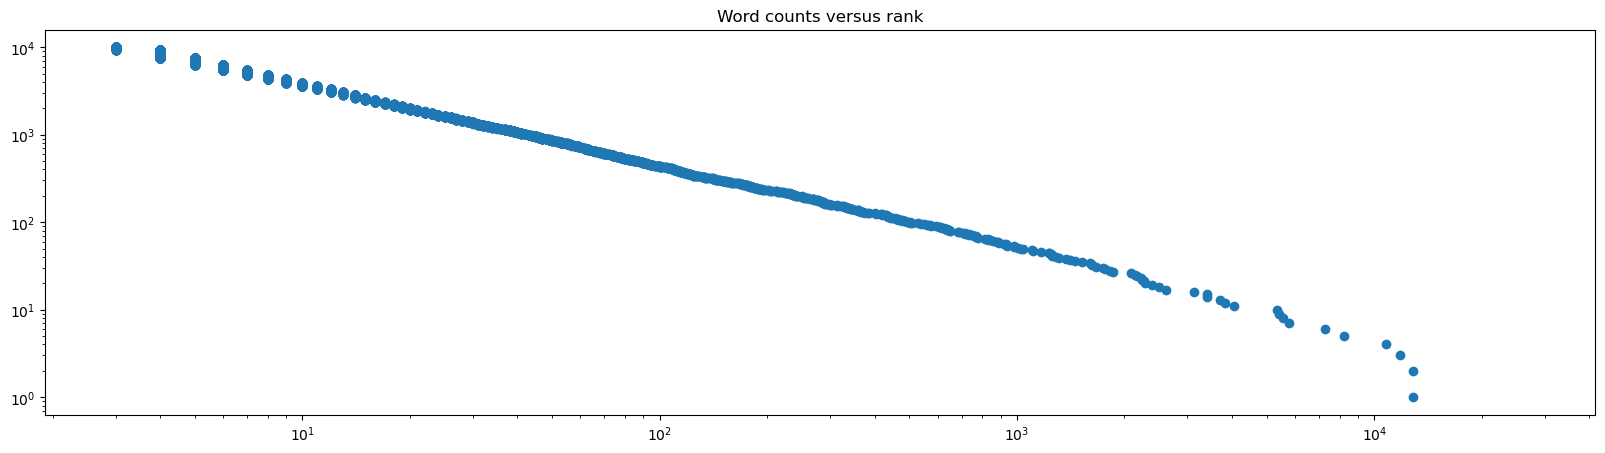

Vocabulary size: 10000
Part of the corpus by taking the "x" most frequent words ?
the pecentage of the data accounted by the first 3100 frequent feature is :90.11%


In [36]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(train_texts_splt)

# here we need to use the logarithmic echelle 
# first get the data in array 
frequency_words = np.array(list(word_counts.values()))
#frequency_words_logarithmic = np.log(frequency_words)
index_label = np.array(list(vocab.values()))
# We can for example use the function plt.scatter()
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(frequency_words,index_label)
plt.yscale('log')
plt.xscale('log')
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
k=3100
# we seek the percentage of the data represented by the first k frequent word

print('Vocabulary size: %i' % (len(vocab)))
print('Part of the corpus by taking the "x" most frequent words ?')

print(f"the pecentage of the data accounted by the first {k} frequent feature is :{round((np.sum(frequency_words[:k]/(np.sum(frequency_words))))*100,2)}%")

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
Word2vec's implementation cuts the vocabulary size by using **only words with at least 5 occurences**, by default. What vocabulary size would it give here ? Does it seem like a good compromise, looking at the graph ? 

In [37]:
vocab, counts_b = vocabulary(train_texts_splt,count_threshold=5)

print('Vocabulary size: %i' % (len(vocab)))


Vocabulary size: 7531


zipf's Law in Action: the observation aligns well with Zipf's law, which predicts that a few words are used very frequently, while the majority are used much less often. The fact that about 30% of your vocabulary can cover over 90% of the text demonstrates the skewed distribution of word usage typical in natural language.

so by looking at the data we can see that the result align well with the law of Zipf,because we see a steep curve starting high and quickly dropping. This curve shows that the most common words are way more frequent than the rest.(which is the Zipf's law)

efficiency vs. Completeness: The analysis allows us to say that focusing on the top 3100 words might be an efficient approach for many NLP tasks. By concentrating on these words, we can significantly reduce the computational resources required (such as memory and processing time) without losing much information. However, this comes at the cost of potentially ignoring rarer words that could carry specific meanings important for certain contexts or analyses.

morever,this approach allows for managing the model's complexity while still retaining a significant portion of meaningful data

### With pre-processing tools from NLTK

We are now going to pre-process our textual data. **Note that this still will only be useful if we do not have a lot of training data to begin with !**

#### Stemming 

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization. Use:
```from nltk import SnowballStemmer```

In [38]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

**Example:**

In [39]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


**Data transformation:**

<div class='alert alert-block alert-info'>
            Code:</div>

In [40]:
def stem(texts):
    texts_copy = texts.copy()
    for i in range(len(texts_copy)):
        arr = texts_copy[i].split()
        for j in range(len(arr)):
            arr[j] = stemmer.stem(arr[j])
        arr = ' '.join(arr)
        texts_copy[i] = arr            
    return texts_copy

In [41]:
test_text = [
    "Hello how are you",
    "What is your favorite color",
    "I like to go for walks in the park",
    "Python programming is fun",
    "Have a great day"
]

print(stem(test_text))
print(train_texts_splt[::10])
print(stem(train_texts_splt[::10]))

['hello how are you', 'what is your favorit color', 'i like to go for walk in the park', 'python program is fun', 'have a great day']
['This movie was pretty absurd. There was a FEW funny parts. Its goes right in to the bin of movies in my memory where I think, "Hmm.....that movie had a few funny parts, but overall, pretty ridiculous plot (or lack of)."<br /><br />I thought it seemed like Ben was trying a little too hard to be a cooky funny guy. And I didn\'t understand how he was a self made multi-millionaire and still such an idiot. Anyways, I like Ben Affleck. He makes some crap, but hey, I can forgive him. I mean, I liked Jersey Girl, I didn\'t think Gigli was all his fault, I like him overall. I guess he\'s kinda like the kid you feel sorry for cuz he just can\'t seem to get it right.<br /><br />My advice would be to avoid this flick. It didn\'t really develop in to a workable plot and Catherine O\'hara and Jimmy G. weren\'t used as well as they could have been. They deserved bett

#### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
```pos_tag```

In [42]:
import nltk
from nltk import pos_tag, word_tokenize

**Example:**

In [43]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pcd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pcd\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

**Data transformation:** only keep nouns, verbs, adverbs, and adjectives (```['NN', 'VB', 'ADJ', 'RB']```) for our model.

<div class='alert alert-block alert-info'>
            Code:</div>

In [44]:
def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB']):
    X_pos = []
    for document in X:
        
        document_tokenized = word_tokenize((document))
        document_tag = pos_tag(document_tokenized)
        document_pos = ' '.join([word for word,i in document_tag if i in good_tags])
        X_pos.append(document_pos)

    return X_pos

### Application

<div class='alert alert-block alert-warning'>
            Questions:</div>

Re-draw the Zipf distribution of our data **after reducing their vocabulary with these functions**. How is it affected ? How do you think it could affect results here ?         
        
<div class='alert alert-block alert-info'>
            Code:</div>        

Vocabulary size of the normal data: 7531
Vocabulary size after stem: 6523
Vocabulary size after Pos_tag: 2567
Vocabulary size after Post_tag and stem: 2495


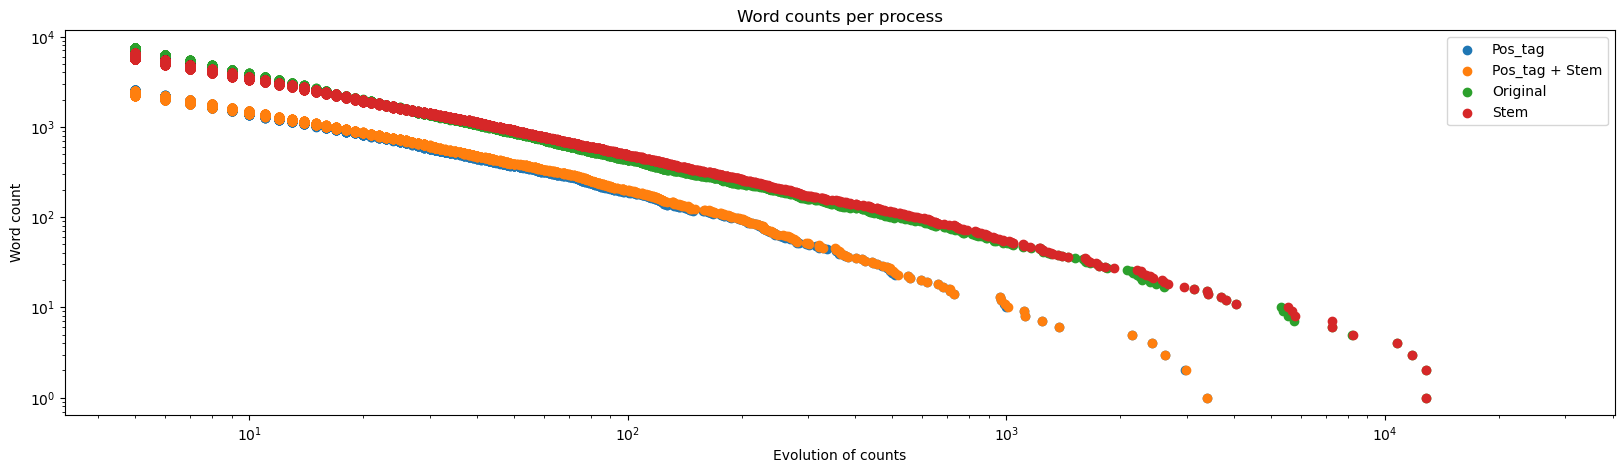

In [45]:
# original data
voc, word_counts = vocabulary(train_texts_splt, count_threshold=5)
data_original = np.array(list(word_counts.values()))
index_label_original = np.array(list(voc.values()))
print('Vocabulary size of the normal data: %i' % (len(voc)))

# stem process
X_stem = stem(train_texts_splt)
voc_stem, word_counts_stem = vocabulary(X_stem, count_threshold=5)
data_stem = np.array(list(word_counts_stem.values()))

index_label_stem = np.array(list(voc_stem.values()))
print('Vocabulary size after stem: %i' % (len(voc_stem)))

# pos_tag process
X_pos = pos_tag_filter(train_texts_splt)
voc_pos, word_counts_pos = vocabulary(X_pos, count_threshold=5)
data_pos_tag = np.array(list(word_counts_pos.values()))
index_label_pos_tag = np.array(list(voc_pos.values()))
print('Vocabulary size after Pos_tag: %i' % (len(voc_pos)))

# stem + pos_tag
X_pos_stem = stem(pos_tag_filter(train_texts_splt))
voc_pos_stem, word_counts_pos_stem = vocabulary(X_pos_stem, count_threshold=5)
data_stem_pos_tag = np.array(list(word_counts_pos_stem.values()))
index_label_stem_pos_tag = np.array(list(voc_pos_stem.values()))
print('Vocabulary size after Post_tag and stem: %i' % (len(voc_pos_stem)))

plt.figure(figsize=(20,5))
plt.title('Word counts per process')
plt.scatter(data_pos_tag,index_label_pos_tag,label='Pos_tag')
plt.scatter(data_stem_pos_tag,index_label_stem_pos_tag,label='Pos_tag + Stem')
plt.scatter(data_original,index_label_original,label='Original')
plt.scatter(data_stem,index_label_stem,label='Stem')
plt.xlabel('Evolution of counts')
plt.ylabel('Word count')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


***Intrepretation Of The Results :***


**first an overview for each methods :**

**Original Data:** : The original data vocabulary illustrates the normal Zipfian distribution.



**Stem Method** : It is a technique tha reduce slightly the size of vocabularies it is based an the snowstrategy where it eliminate the morphological variations.

Based on the output of the code and the graph, we can see that it has a distribution that is almost like the one founded by the data without any preprocessing process, the number of vocabularies is 6523, and it is clear that the distribution is smoother where a frequency of some word increase,where it is higher the one that used Pos_tag.

the distribution resembles the Zipfian distribution.


**Pos_tag** : This method aims to extract from the original data the significant words like the verb , adjective ,noun,.. which is beneficial for some application especially in the our application where the adjective could express the sentiment or even the verbs

In the output of the code we can see that it reduces the number of vocabularies to 2567 which is lower that the one obtained from Pos_tag , in other word it eliminates more than 50% of the words that are less informative ,it allows ato simplifies the model.

Based on the graph the distribution looks more straight and the frequency of some words decrease compared to stem for example the word "the" appeared ,mostly, in every document this one is eliminated by Pos_tag showing that such a word is less informative, that is why we started by a word that has a lower frequency compared the starting points in original data and stem data.



**Pos_tag + Stem** :

When we use both Pos_tag with stem, the number of different words gets even smaller (down to 2495). Doing this makes the model simpler and faster, which could be good. But it might also make it harder to understand some of the finer details in the text.


based on the graph the result is approximately equal to the result obtained from the Pos_tag but here it reduced more the number of words so that the frequency reduces as well.



***Implications for NLP Tasks:***

**1. Computational Efficiency**
Reducing vocabulary sizes enhances computational speed and reduces memory usage by decreasing the amount of data processed. This efficiency allows for training on larger datasets and using less powerful hardware more effectively, reducing both time and costs associated with model training and deployment.

**2. Model Performance**
The impact on model performance varies by task: precision-demanding tasks may suffer from oversimplification, while broader-context tasks could benefit from a focus on key content. Balancing vocabulary complexity is crucial for optimizing accuracy and relevance in NLP tasks.

**3. Overfitting Risk**
A smaller vocabulary reduces overfitting by limiting the model's ability to learn irrelevant details and spurious correlations from the training data. This encourages the learning of more generalizable patterns, improving model robustness.

**4. Generalization**
Models trained with a streamlined vocabulary tend to generalize better to new data, focusing on the most significant language aspects. This makes them more adaptable across different domains or tasks without needing extensive retraining.